In [62]:
# Import all the goods
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import iqr
plt.style.use('seaborn-whitegrid')

# Import the data files
xl_01 = pd.ExcelFile('20190927_HeartSurvey_edited.xlsx')
survey = xl_01.parse("Sheet1")
xl_02 = pd.ExcelFile('Survey questions key.xlsx')
survey_key = xl_02.parse("Sheet1")

## Extract observer risk scores to its own dataframe
risk = survey.iloc[:, 10:130:2].fillna(50).T ## All the actual questions, risk value
## Rename columns to match observer ID
risk.columns = [i+1 for i in range(12)]
## Rename indices to actual numbers, instead of the crazy codes
risk.index = [i for i in range(60)]

## Extract waitlist decision data to its own dataframe
decision = survey.iloc[:, 11:130:2].T ## All the actual questions, risk value
## Rename waitlist decision columns to match the risk columns
decision.columns = [i+1 for i in range(12)]

## Extract SRTR Risk scores
srtr_risk = pd.DataFrame(survey_key["SRTR Risk"])
## Create a scaled SRTR Risk key
scaler = MinMaxScaler(feature_range=(0,100))
scaled_srtr_risk = scaler.fit_transform(srtr_risk)
scaled_srtr_risk = pd.DataFrame(scaled_srtr_risk, columns=['Scaled SRTR Risk'])

# Create a master dataframe
## Add to the observer risk dataframe SRTR scores and Question IDs as extra columns
risk.insert(0,'Scaled SRTR Risk', scaled_srtr_risk)
risk.insert(0,'SRTR Risk', srtr_risk)
risk.insert(0,'Scenario ID', [i+1 for i in range(60)])
## Unpivot the observer risk dataframe
data_temp = pd.melt(risk, id_vars=['Scenario ID', 'SRTR Risk', 'Scaled SRTR Risk'], var_name='Observer ID', value_name='Observer Risk')
## Add to the unpivoted table all the decisions
data_temp.insert(0,'Observer Decision', pd.melt(decision).value)
## Finally, reorganize the columns
master_data = data_temp[['Scenario ID', 'SRTR Risk', 'Scaled SRTR Risk', 'Observer ID', 'Observer Risk', 'Observer Decision']]

master_data.head()

,Scenario ID,SRTR Risk,Scaled SRTR Risk,Observer ID,Observer Risk,Observer Decision
0,1,15.51,46.304263,1,50.0,Yes
1,2,26.40,88.893234,1,92.0,No
2,3,7.36,14.430974,1,63.0,Yes
3,4,4.01,1.329683,1,0.0,Yes
4,5,3.67,0.000000,1,100.0,No


Text(0.5, 0, 'Risk Score')

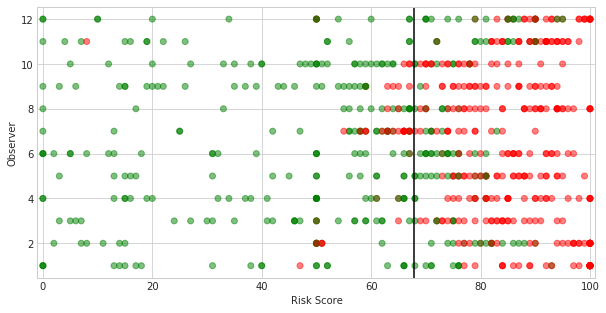

In [7]:
# All scenarios stacked into one chart, with a Mean of Means line thrown in
plt.rcParams['figure.figsize'] = [10, 5]
x = master_data['Observer Risk']
y = master_data['Observer ID']
colors = master_data['Observer Decision'].replace(['Yes', 'No'], ['green', 'red'])

plt.scatter(x, y, marker='o', color=colors, alpha=0.5)
plt.axvline(x=master_data['Observer Risk'].mean(), color='black')
plt.xlim(-1, 101)
plt.ylabel('Observer')
plt.xlabel('Risk Score')


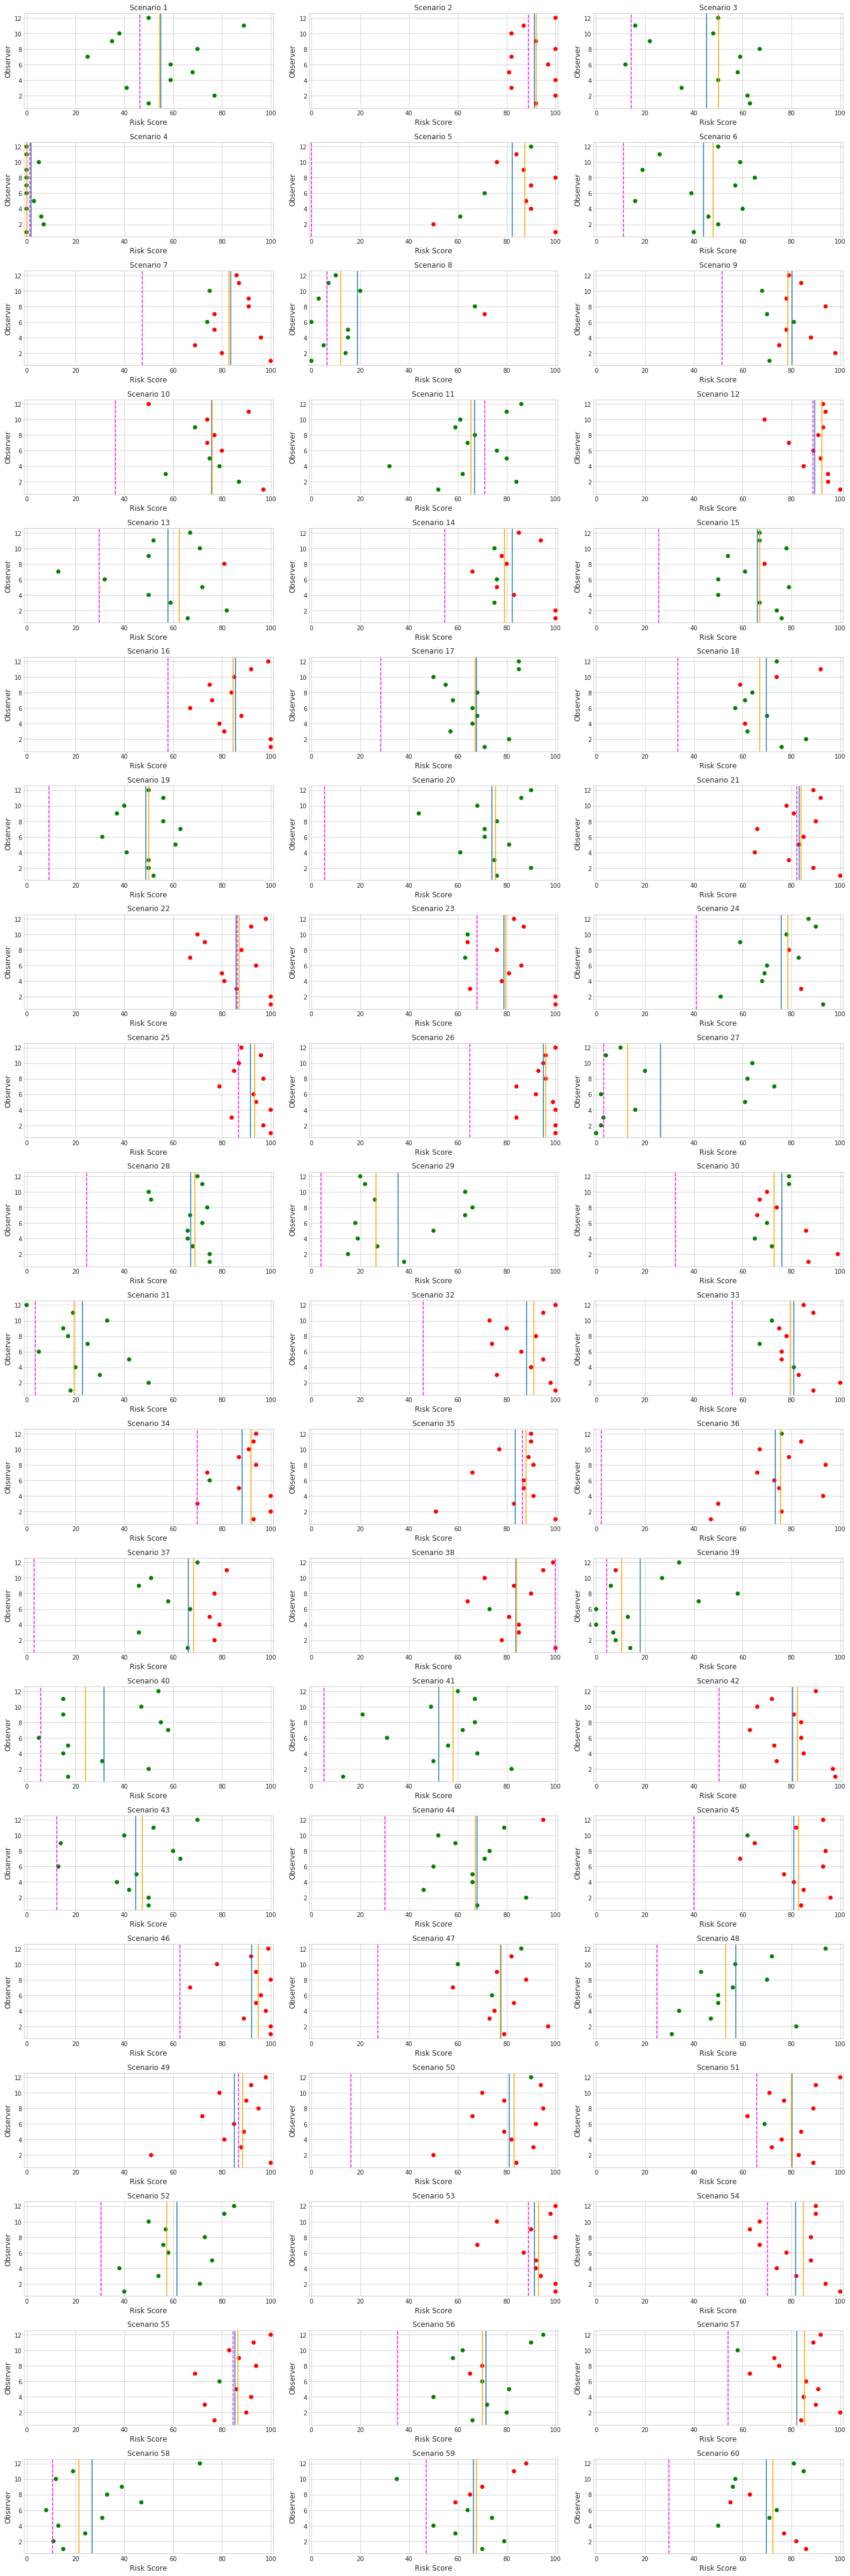

In [8]:
## Plot observer risk/decision for each scenario
#    Mean = blue line
#    Median = orange line
#    Scaled SRTR risk = dotted magenta line

def plotAllScenarios(df):
    plt.rcParams['figure.figsize'] = [20, 60]
    fig, axs = plt.subplots(20, 3)
    scenario = 1
    for i in range(20):
        for j in range(3):
            risk     = df[df['Scenario ID'] == scenario]['Observer Risk']
            observer = df[df['Scenario ID'] == scenario]['Observer ID']
            colors   = df[df['Scenario ID'] == scenario]['Observer Decision'].replace(['Yes', 'No'], ['green', 'red'])
            srtr     = df[df['Scenario ID'] == scenario]['Scaled SRTR Risk'].max()
            axs[i, j].set_xlim([-1, 101])
            axs[i, j].scatter(risk, observer, color=colors)
            axs[i, j].axvline(x=risk.mean())
            axs[i, j].axvline(x=risk.median(), color='orange')
            axs[i, j].axvline(x=srtr, color='magenta', linestyle='--')
            axs[i, j].set_title(f'Scenario {scenario}', fontsize='large')
            axs[i, j].set_ylabel('Observer', fontsize='large')
            axs[i, j].set_xlabel('Risk Score', fontsize='large')
            scenario += 1
    plt.tight_layout()
    
plotAllScenarios(master_data)

In [4]:
results_a = master_data.loc[(master_data['Scenario ID'] <= 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]
results_b = master_data.loc[(master_data['Scenario ID'] > 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]

results_a.groupby('Scenario ID').mean().sort_values('Observer Risk').index

Int64Index([ 4,  8, 27, 29,  6,  3, 19,  1, 13, 15, 11, 28, 17, 18, 20, 10, 24,
            30, 23,  9,  5, 14, 21,  7, 16, 22, 12,  2, 25, 26],
           dtype='int64', name='Scenario ID')

Text(0.5, 0.98, 'Scenario Risk Scores')

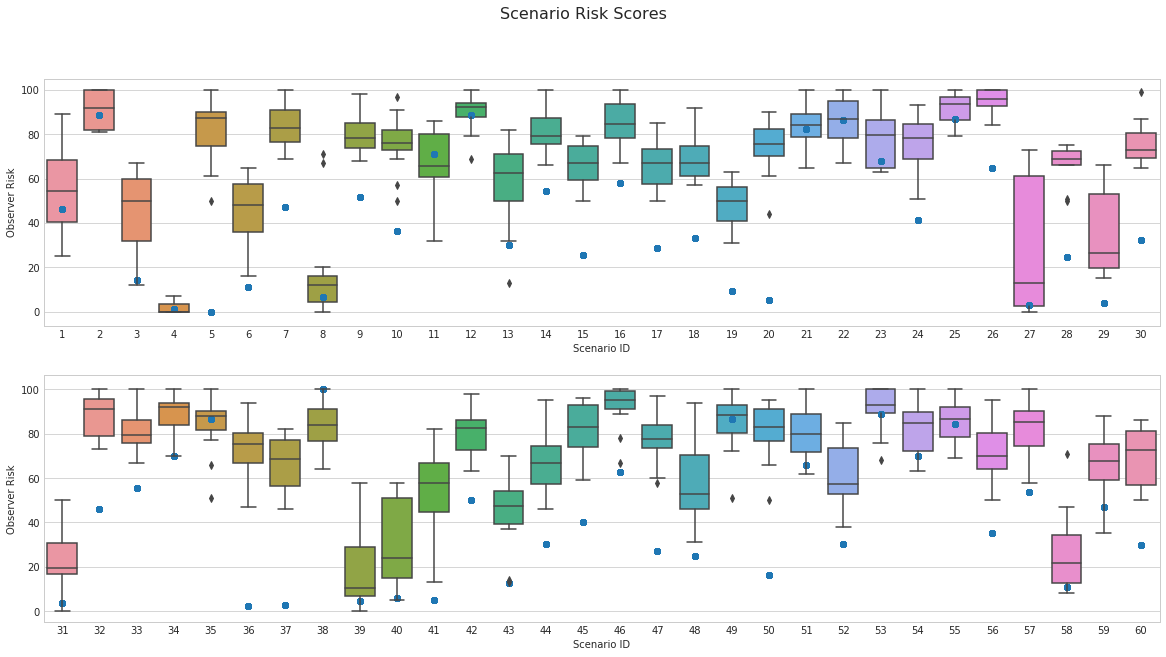

In [11]:
## Box plot
#  Shows median, 1.5 interquartile range, and range of scores for each scenario
#  Scaled SRTR Score = blue dot

plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
ax_1 = sns.boxplot(x='Scenario ID', y='Observer Risk', data=results_a)
ax_1 = plt.scatter(results_a['Scenario ID']-1, results_a['Scaled SRTR Risk'])

plt.subplot(2, 1, 2)
ax_2 = sns.boxplot(x='Scenario ID', y='Observer Risk', data=results_b)
ax_2 = plt.scatter(results_b['Scenario ID']-31, results_b['Scaled SRTR Risk'])

plt.suptitle('Scenario Risk Scores', fontsize=16)

#plt.savefig('plot_BoxPerScenario.jpg')

Text(0.5, 0.98, 'Scenario Risk Scores, sorted by SRTR risk')

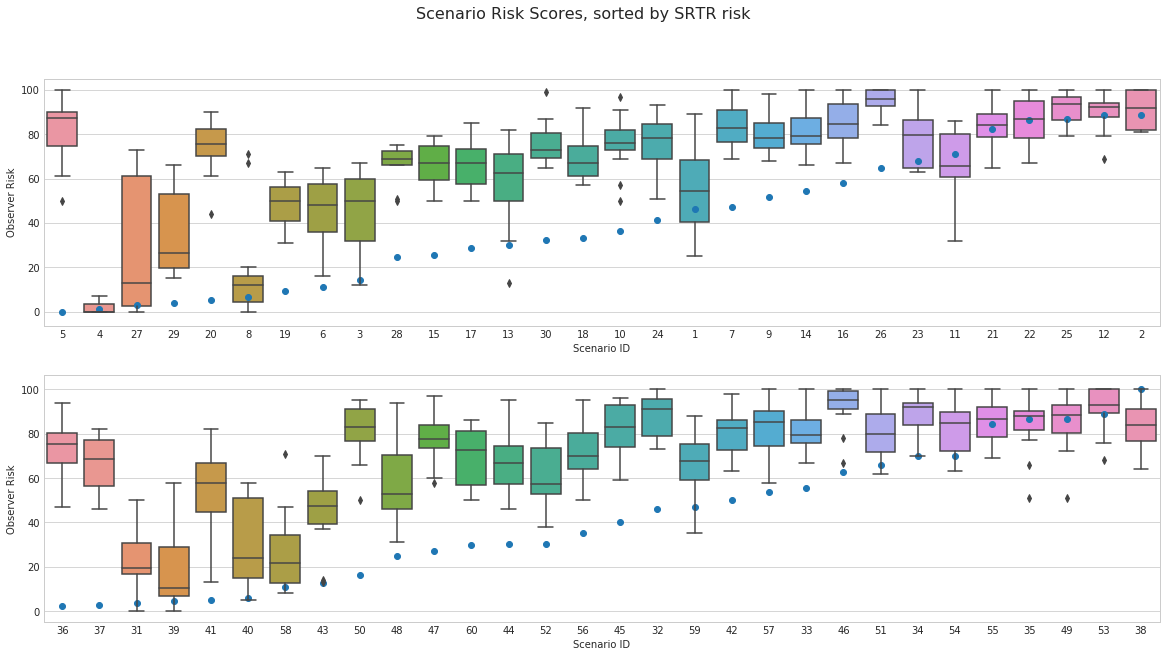

In [12]:
## Same as above, but sorted by increasing SRTR risk score

plt.figure(figsize=(20, 10))

sorted_results_a = results_a.sort_values('Scaled SRTR Risk')[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()['Scenario ID']
sorted_srtr_a = results_a[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates().sort_values('Scaled SRTR Risk')
sorted_results_b = results_b.sort_values('Scaled SRTR Risk')[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()['Scenario ID']
sorted_srtr_b = results_b[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates().sort_values('Scaled SRTR Risk')

plt.subplot(2, 1, 1)
ax_1 = sns.boxplot(x='Scenario ID', y='Observer Risk', data=results_a, order=sorted_results_a)
ax_1 = plt.scatter([i for i in range(30)], sorted_srtr_a['Scaled SRTR Risk'])

plt.subplot(2, 1, 2)
ax_2 = sns.boxplot(x='Scenario ID', y='Observer Risk', data=results_b, order=sorted_results_b)
ax_2 = plt.scatter([i for i in range(30)], sorted_srtr_b['Scaled SRTR Risk'])

plt.suptitle('Scenario Risk Scores, sorted by SRTR risk', fontsize=16)

#plt.savefig('plot_BoxPerScenario_sortSRTR.jpg')

Text(0.5, 0.98, 'Scenario Risk Scores, sorted by SRTR risk')

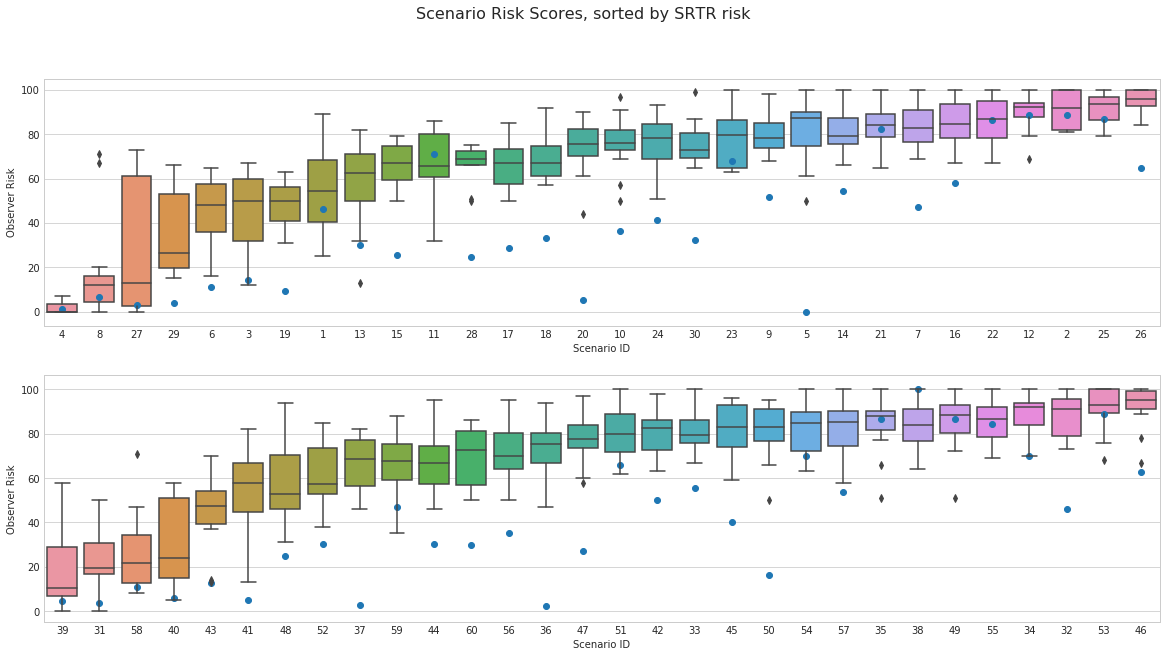

In [47]:
## Same as above, but sorted by increasing observer mean risk score

plt.figure(figsize=(20, 10))

sorted_results_a = results_a.groupby('Scenario ID').mean().sort_values('Observer Risk').index
sorted_srtr_a = results_a.groupby('Scenario ID').mean().sort_values('Observer Risk')
sorted_results_b = results_b.groupby('Scenario ID').mean().sort_values('Observer Risk').index
sorted_srtr_b = results_b.groupby('Scenario ID').mean().sort_values('Observer Risk')

plt.subplot(2, 1, 1)
ax_1 = sns.boxplot(x='Scenario ID', y='Observer Risk', data=results_a, order=sorted_results_a)
ax_1 = plt.scatter([i for i in range(30)], sorted_srtr_a['Scaled SRTR Risk'])

plt.subplot(2, 1, 2)
ax_2 = sns.boxplot(x='Scenario ID', y='Observer Risk', data=results_b, order=sorted_results_b)
ax_2 = plt.scatter([i for i in range(30)], sorted_srtr_b['Scaled SRTR Risk'])

plt.suptitle('Scenario Risk Scores, sorted by SRTR risk', fontsize=16)

#plt.savefig('plot_BoxPerScenario_sortSRTR.jpg')

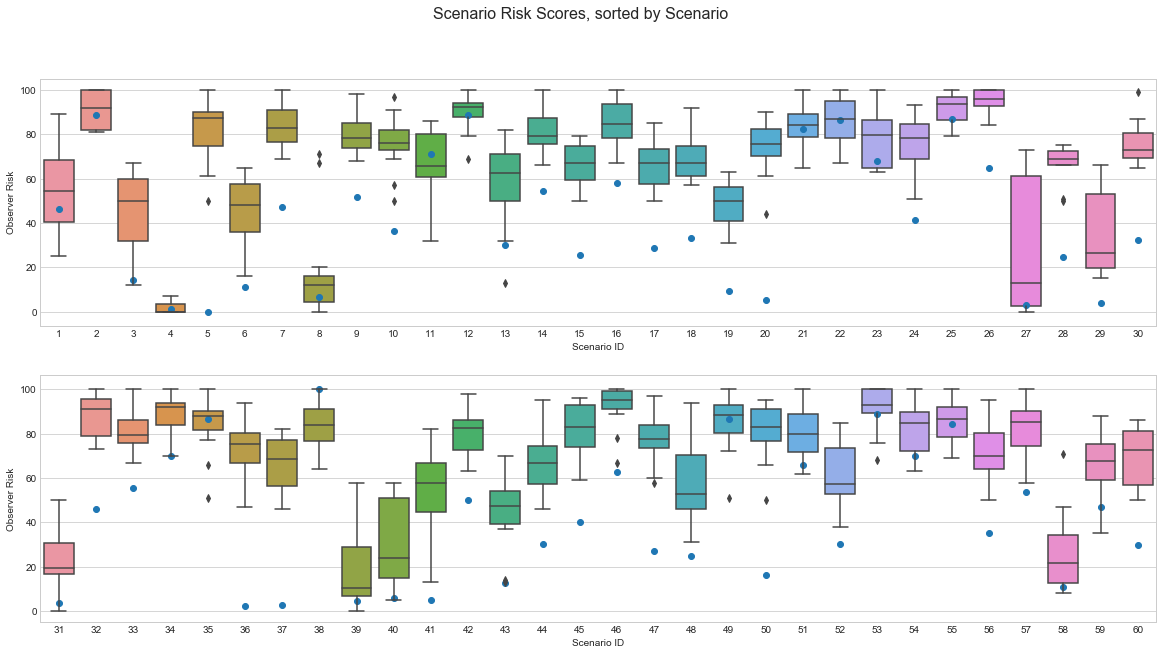

In [195]:
## Same as above, but sorted by increasing observer mean risk score

def results_sorted_by_srtr(df):
    results_a = df.loc[(df['Scenario ID'] <= 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]
    results_b = df.loc[(df['Scenario ID'] > 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]
    results_a_sorted =     results_a.sort_values('Scaled SRTR Risk')
    results_b_sorted =     results_b.sort_values('Scaled SRTR Risk')
    results_a_sort_order = results_a_sorted['Scenario ID'].drop_duplicates()
    results_b_sort_order = results_b_sorted['Scenario ID'].drop_duplicates()
    srtr_a_sorted = results_a_sorted[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()
    srtr_a_sorted.index = [i for i in range(30)]
    srtr_b_sorted = results_b_sorted[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()
    srtr_b_sorted.index = [i for i in range(30)]
    return {
        'title':                      'Scaled SRTR Risk Score',
        'first_results':              results_a,
        'first_results_sorted':       results_a_sorted,
        'first_results_sort_order':   results_a_sort_order,
        'first_srtr_sorted':          srtr_a_sorted,
        'second_results':             results_b,
        'second_results_sorted':      results_b_sorted,
        'second_results_sort_order':  results_b_sort_order,
        'second_srtr_sorted':         srtr_b_sorted
    }

def results_sorted_by_mean(df):
    results_a = df.loc[(df['Scenario ID'] <= 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]
    results_b = df.loc[(df['Scenario ID'] > 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]
    results_a_sorted =     results_a.groupby('Scenario ID').mean().sort_values('Observer Risk').reset_index()
    results_b_sorted =     results_b.groupby('Scenario ID').mean().sort_values('Observer Risk').reset_index()
    results_a_sort_order = results_a_sorted['Scenario ID'].drop_duplicates()
    results_b_sort_order = results_b_sorted['Scenario ID'].drop_duplicates()
    srtr_a_sorted = results_a_sorted[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()
    srtr_a_sorted.index = [i for i in range(30)]
    srtr_b_sorted = results_b_sorted[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()
    srtr_b_sorted.index = [i for i in range(30)]
    return {
        'title':                      'Mean Observer Risk Score',
        'first_results':              results_a,
        'first_results_sorted':       results_a_sorted,
        'first_results_sort_order':   results_a_sort_order,
        'first_srtr_sorted':          srtr_a_sorted,
        'second_results':             results_b,
        'second_results_sorted':      results_b_sorted,
        'second_results_sort_order':  results_b_sort_order,
        'second_srtr_sorted':         srtr_b_sorted
    }

def results_sorted_by_median(df):
    results_a = df.loc[(df['Scenario ID'] <= 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]
    results_b = df.loc[(df['Scenario ID'] > 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]
    results_a_sorted =     results_a.groupby('Scenario ID').median().sort_values('Observer Risk').reset_index()
    results_b_sorted =     results_b.groupby('Scenario ID').median().sort_values('Observer Risk').reset_index()
    results_a_sort_order = results_a_sorted['Scenario ID'].drop_duplicates()
    results_b_sort_order = results_b_sorted['Scenario ID'].drop_duplicates()
    srtr_a_sorted = results_a_sorted[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()
    srtr_a_sorted.index = [i for i in range(30)]
    srtr_b_sorted = results_b_sorted[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()
    srtr_b_sorted.index = [i for i in range(30)]
    return {
        'title':                      'Median Observer Risk Score',
        'first_results':              results_a,
        'first_results_sorted':       results_a_sorted,
        'first_results_sort_order':   results_a_sort_order,
        'first_srtr_sorted':          srtr_a_sorted,
        'second_results':             results_b,
        'second_results_sorted':      results_b_sorted,
        'second_results_sort_order':  results_b_sort_order,
        'second_srtr_sorted':         srtr_b_sorted
    }


def results_sorted_by_scenario(df):
    results_a = df.loc[(df['Scenario ID'] <= 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]
    results_b = df.loc[(df['Scenario ID'] > 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]
    results_a_sorted = results_a
    results_b_sorted = results_b
    results_a_sort_order = results_a_sorted['Scenario ID'].drop_duplicates()
    results_b_sort_order = results_b_sorted['Scenario ID'].drop_duplicates()
    srtr_a_sorted = results_a_sorted[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()
    srtr_a_sorted.index = [i for i in range(30)]
    srtr_b_sorted = results_b_sorted[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()
    srtr_b_sorted.index = [i for i in range(30)]
    return {
        'title':                      'Scenario',
        'first_results': results_a,
        'first_results_sorted': results_a_sorted,
        'first_results_sort_order': results_a_sort_order,
        'first_srtr_sorted': srtr_a_sorted,
        'second_results': results_b,
        'second_results_sorted': results_b_sorted,
        'second_results_sort_order': results_b_sort_order,
        'second_srtr_sorted': srtr_b_sorted
    }

def results_sorted_by_interquartitle_range(df):
    from scipy.stats import iqr
    results_a = df.loc[(df['Scenario ID'] <= 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]
    results_b = df.loc[(df['Scenario ID'] > 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]
    # Make two lists of interquartile ranges
    iqr_list = []
    for scenario in df['Scenario ID']:
        iqr_list.append(iqr(df[df['Scenario ID'] == scenario]['Observer Risk']))
    iqr_df = pd.DataFrame(iqr_list, columns=['IQR'])
    iqr_df = iqr_df[:60]
    iqr_df.insert(0, 'Scenario ID', [i+1 for i in range(60)])
    iqr_df.insert(2, 'Scaled SRTR Risk', df[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()['Scaled SRTR Risk'])
    iqr_a = iqr_df[:30]
    iqr_b = iqr_df[30:]
    results_a_sorted = iqr_a.sort_values('IQR')
    results_a_sort_order = results_a_sorted['Scenario ID']
    srtr_a_sorted = results_a_sorted
    srtr_a_sorted.index = [i for i in range(30)]
    results_b_sorted = iqr_b.sort_values('IQR')
    results_b_sort_order = results_b_sorted['Scenario ID']
    srtr_b_sorted = results_b_sorted
    srtr_b_sorted.index = [i for i in range(30)]
    return {
        'title':                      'Interquartile Range',
        'first_results':              results_a,
        'first_results_sorted':       results_a_sorted,
        'first_results_sort_order':   results_a_sort_order,
        'first_srtr_sorted':          srtr_a_sorted,
        'second_results':             results_b,
        'second_results_sorted':      results_b_sorted,
        'second_results_sort_order':  results_b_sort_order,
        'second_srtr_sorted':         srtr_b_sorted
    }

    
def boxplot_survey(df, sort_by='scenario'):
    plt.figure(figsize=(20, 10))
    if (sort_by == 'mean'):
        results = results_sorted_by_mean(df)
    if (sort_by == 'scenario'):
        results = results_sorted_by_scenario(df)
    if (sort_by == 'srtr'):
        results = results_sorted_by_srtr(df)
    if (sort_by == 'median'):
        results = results_sorted_by_median(df)
    if (sort_by == 'iqr'):
        results = results_sorted_by_interquartitle_range(df)
    first_results = results['first_results']
    first_results_sorted = results['first_results_sorted']
    first_results_sort_order = results['first_results_sort_order']
    first_srtr_sorted = results['first_srtr_sorted']
    second_results = results['second_results']
    second_results_sorted = results['second_results_sorted']
    second_results_sort_order = results['second_results_sort_order']
    second_srtr_sorted = results['second_srtr_sorted']

    plt.subplot(2, 1, 1)
    ax_1 = sns.boxplot(x='Scenario ID', y='Observer Risk', data=first_results, order=first_results_sort_order)
    ax_1 = plt.scatter(first_srtr_sorted.index.values, first_srtr_sorted['Scaled SRTR Risk'])
    
    plt.subplot(2, 1, 2)
    ax_2 = sns.boxplot(x='Scenario ID', y='Observer Risk', data=second_results, order=second_results_sort_order)
    ax_2 = plt.scatter(second_srtr_sorted.index.values, second_srtr_sorted['Scaled SRTR Risk'])
    
    plt.suptitle(f'Scenario Risk Scores, sorted by {results["title"]}', fontsize=16)



boxplot_survey(master_data)

plt.savefig('plot_BoxPerScenario.jpg')



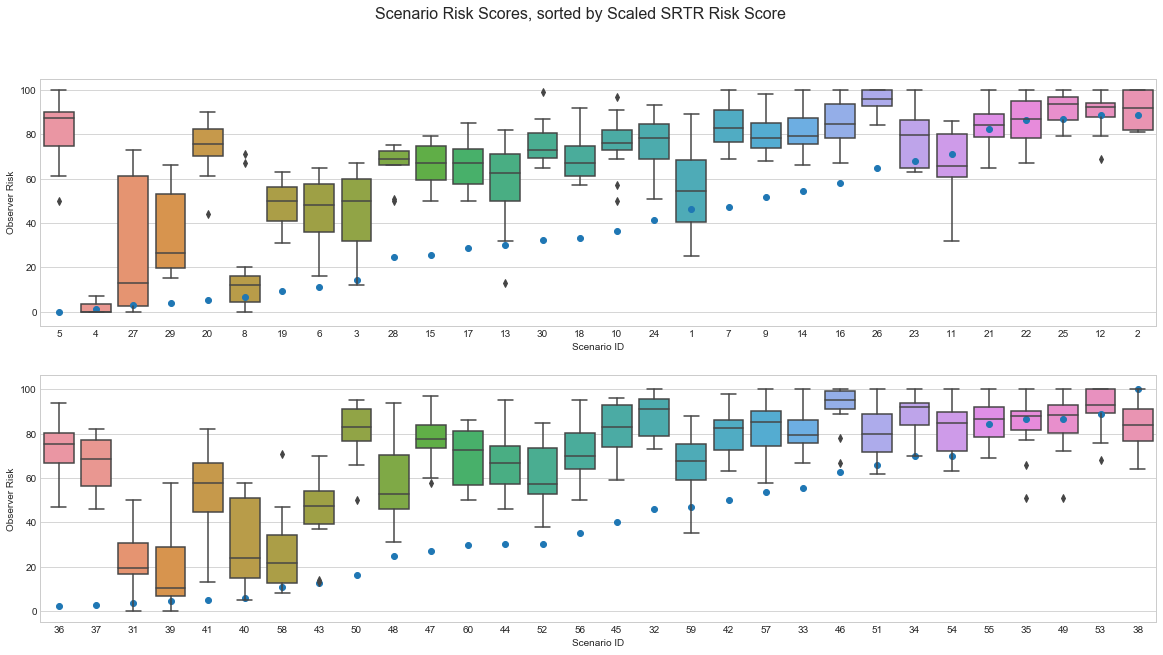

In [196]:
boxplot_survey(master_data, 'srtr')
plt.savefig('plot_BoxPerScenario_sortSRTR.jpg')

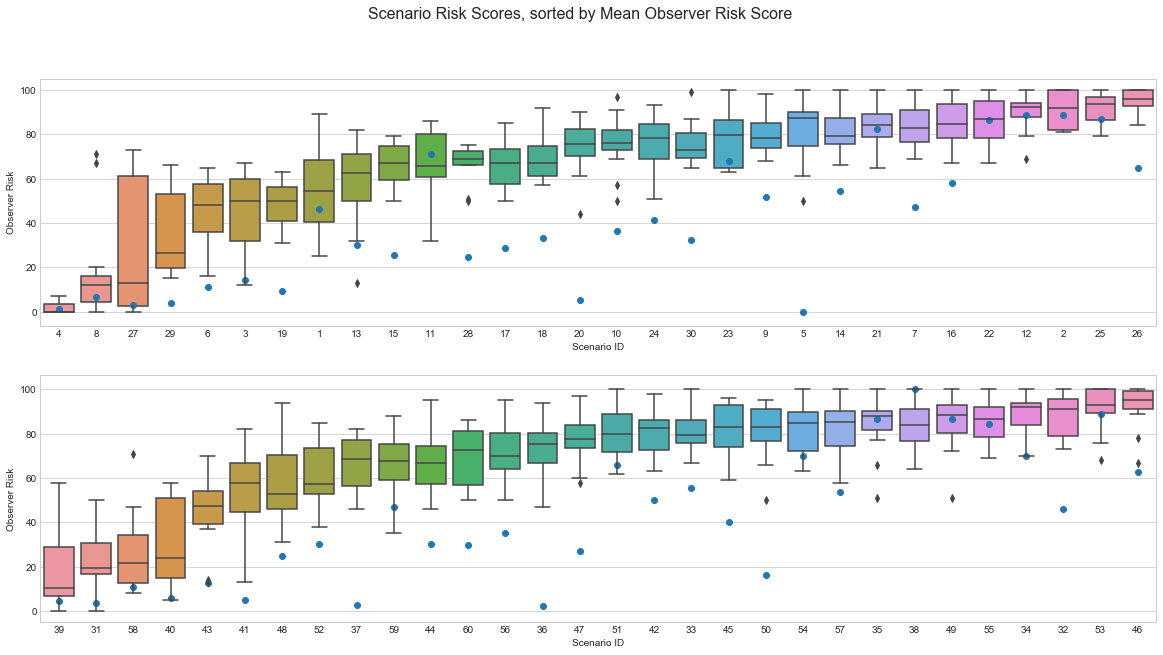

In [197]:
boxplot_survey(master_data, 'mean')
plt.savefig('plot_BoxPerScenario_sortMean.jpg')

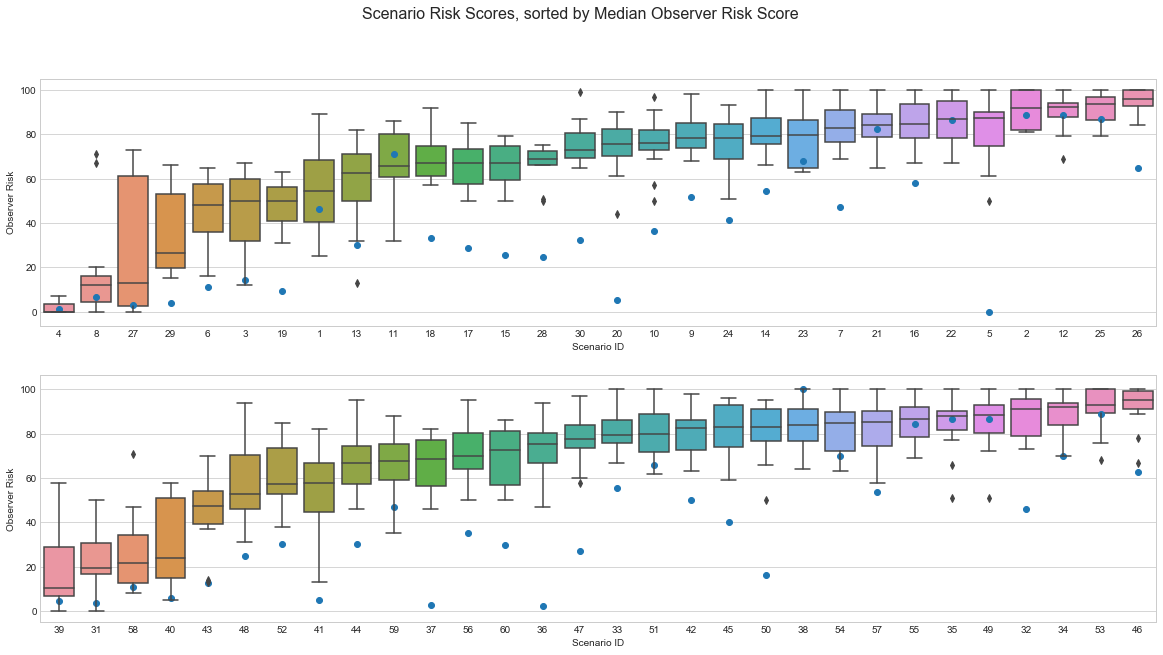

In [198]:
boxplot_survey(master_data, 'median')
plt.savefig('plot_BoxPerScenario_sortMedian.jpg')

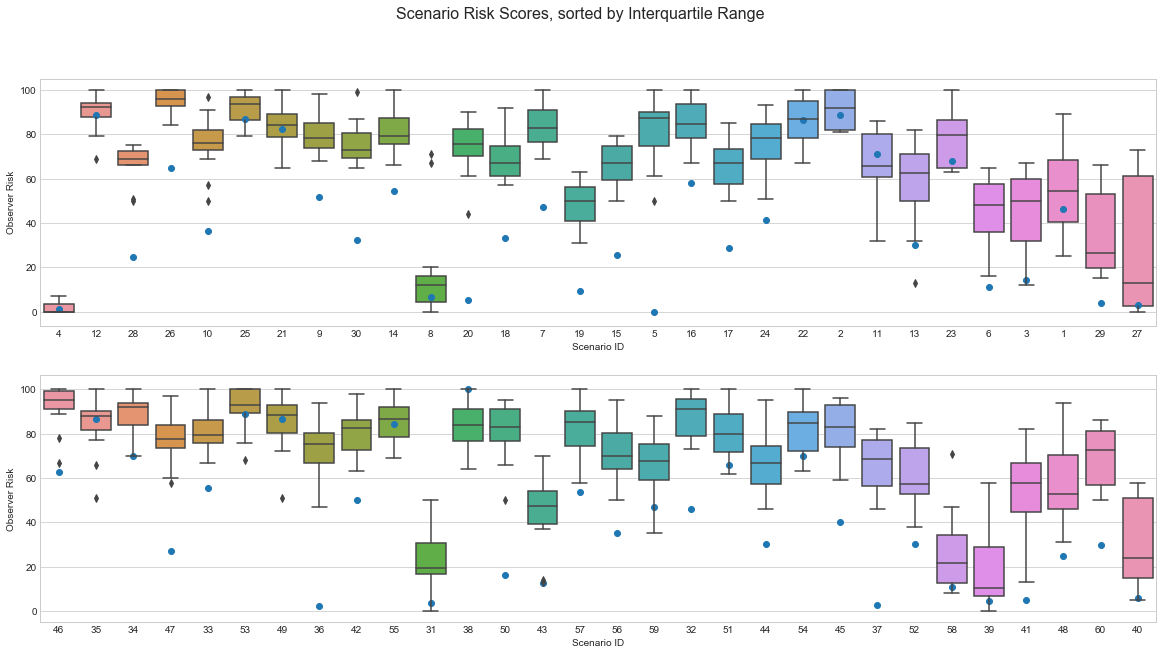

In [199]:
boxplot_survey(master_data, 'iqr')
plt.savefig('plot_BoxPerScenario_sortIQR.jpg')

In [130]:
def calculateDeviationFromMeanByObserver(df, start_scenario=1, stop_scenario=60):
    """Calculates Mean Squared Error against the overall mean for that observer"""
    mse = []
    number_of_observers = df['Observer ID'].max()
    scenarios = (df['Scenario ID'] >= start_scenario) & (df['Scenario ID'] <= stop_scenario)
    for observer in range(number_of_observers):
        scores = df[scenarios & (df['Observer ID'] == observer+1)]['Observer Risk']
        scores_mean = scores.mean()
        n = len(scores)
        mse.append((1/n)*np.sum((scores - scores_mean)**2))
    return np.array(mse)
    
mse_noscore = calculateDeviationFromMeanByObserver(master_data, 1, 30)
mse_withscore = calculateDeviationFromMeanByObserver(master_data, 31, 60)

for i in range(len(mse_noscore)):
    print(f'Observer {i+1}:  Without score {mse_noscore[i]},\t With score {mse_withscore[i]}')

Observer 1:  Without score 957.1833333333333,	 With score 920.0622222222224
Observer 2:  Without score 880.4722222222222,	 With score 610.7433333333333
Observer 3:  Without score 584.5733333333334,	 With score 506.2455555555555
Observer 4:  Without score 698.1122222222223,	 With score 773.0988888888892
Observer 5:  Without score 498.53888888888895,	 With score 469.71555555555557
Observer 6:  Without score 860.1555555555555,	 With score 830.3955555555555
Observer 7:  Without score 373.8622222222223,	 With score 95.44000000000001
Observer 8:  Without score 345.16555555555556,	 With score 370.9066666666667
Observer 9:  Without score 710.4100000000001,	 With score 660.978888888889
Observer 10:  Without score 365.05,	 With score 307.31222222222226
Observer 11:  Without score 949.2322222222224,	 With score 653.5955555555557
Observer 12:  Without score 788.25,	 With score 467.76555555555564


In [156]:
def calculateDeviationFromSRTRByObserver(df, srtr, start_scenario=1, stop_scenario=60):
    """Calculates Mean Squared Error against each SRTR score for the observer"""
    mse = []
    number_of_observers = df['Observer ID'].max()
    scenarios = (df['Scenario ID'] >= start_scenario) & (df['Scenario ID'] <= stop_scenario)
    for observer in range(number_of_observers):
        scores = df[scenarios & (df['Observer ID'] == observer+1)]['Observer Risk']
        srtr_scores = df[scenarios]['SRTR Risk'].drop_duplicates()
        n = len(scores)
        print(number_of_observers)
        mse.append((1/n)*np.sum((scores - srtr_scores)**2))
        # print(f'MSE, Observer {observer + 1}:\t{mse[observer]}  (numerator: {np.sum((x-x_mean)**2)}, denominator: {len(x)})')
    return np.array(mse)
    
mse_noscore = calculateDeviationFromSRTRByObserver(master_data, 1, 30)
mse_withscore = calculateDeviationFromSRTRByObserver(master_data, 31, 60)

for i in range(len(mse_noscore)):
    print(f'Observer {i+1}:  Without score {mse_noscore[i]}, With score {mse_withscore[i]}')

12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
Observer 1:  Without score 3698.753612903226, With score 5584.572900000001
Observer 2:  Without score 0.0, With score 0.0
Observer 3:  Without score 0.0, With score 0.0
Observer 4:  Without score 0.0, With score 0.0
Observer 5:  Without score 0.0, With score 0.0
Observer 6:  Without score 0.0, With score 0.0
Observer 7:  Without score 0.0, With score 0.0
Observer 8:  Without score 0.0, With score 0.0
Observer 9:  Without score 0.0, With score 0.0
Observer 10:  Without score 0.0, With score 0.0
Observer 11:  Without score 0.0, With score 0.0
Observer 12:  Without score 0.0, With score 0.0


In [157]:
observer = 3
df = master_data
start_scenario = 31
stop_scenario = 60
number_of_observers = df['Observer ID'].max()
scenarios = (df['Scenario ID'] >= start_scenario) & (df['Scenario ID'] <= stop_scenario)
scores = df[scenarios & (df['Observer ID'] == observer+1)]['Observer Risk']
srtr_scores = df[scenarios]['SRTR Risk'].drop_duplicates()
n = len(scores)
scores.index = range(30)
(1/n)*np.sum((scores - srtr_scores)**2)
scores

0      20.0
1      90.0
2      81.0
3     100.0
4      91.0
5      93.0
6      79.0
7      85.0
8       0.0
9      15.0
10     68.0
11     85.0
12     37.0
13     66.0
14     81.0
15     98.0
16     75.0
17     34.0
18     81.0
19     82.0
20     76.0
21     38.0
22     92.0
23     74.0
24     92.0
25     50.0
26     85.0
27     13.0
28     50.0
29     50.0
Name: Observer Risk, dtype: float64

In [90]:
mask = (master_data['Scenario ID'] >= 1) & (master_data['Scenario ID'] <= 30)
mask_2 = (master_data['Observer ID'] == 1)
scores = master_data[mask & mask_2]['Observer Risk']
scores_mean = scores.mean()
n = len(scores)
(1/n)*np.sum((scores - scores_mean)**2)

957.1833333333333

In [ ]:
## Plot "mean squared error" across providers, split by Mean/SRTR Score, and by With/Without SRTR Score

mse_mean_blind = calculateDeviationFromMeanByObserver(risk, 1, 30)
mse_mean = calculateDeviationFromMeanByObserver(risk, 31, 60)
mse_srtr_blind = calculateDeviationFromSRTRByObserver(risk, scaled_srtr_risk, 1, 30)
mse_srtr = calculateDeviationFromSRTRByObserver(risk, scaled_srtr_risk, 31, 60)

deviations = pd.DataFrame(
               np.array([mse_mean_blind, mse_mean]),
               index=['Deviation from Mean, without SRTR', 'Deviation from Mean, with SRTR'])

changes = pd.DataFrame(
               np.array([mse_mean - mse_mean_blind, mse_srtr - mse_srtr_blind]),
               index=['Change in Deviation from Mean, without -> with', 'Change in Deviation from SRTR, without -> with'])

plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
ax_1 = sns.boxplot(data=deviations.T, orient='h')


plt.subplot(2, 1, 2)
ax_2 = sns.boxplot(data=changes.T, orient='h')


plt.savefig('plot_BoxDeviations.jpg')

Text(0, 0.5, 'Observer Risk Score')

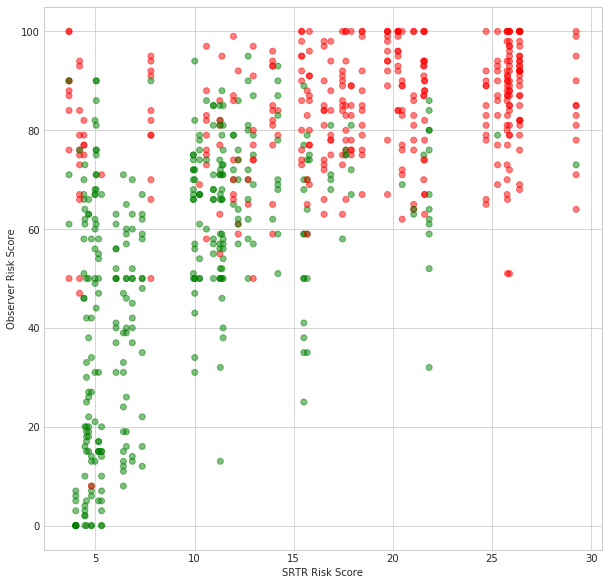

In [16]:
colors = master_data['Observer Decision'].replace(['Yes', 'No'], ['green', 'red'])

plt.figure(figsize=(10, 10))
plt.scatter(master_data['SRTR Risk'], master_data['Observer Risk'], color=colors, alpha=0.5)
plt.xlabel('SRTR Risk Score')
plt.ylabel('Observer Risk Score')

Text(0, 0.5, 'Observer Risk Score')

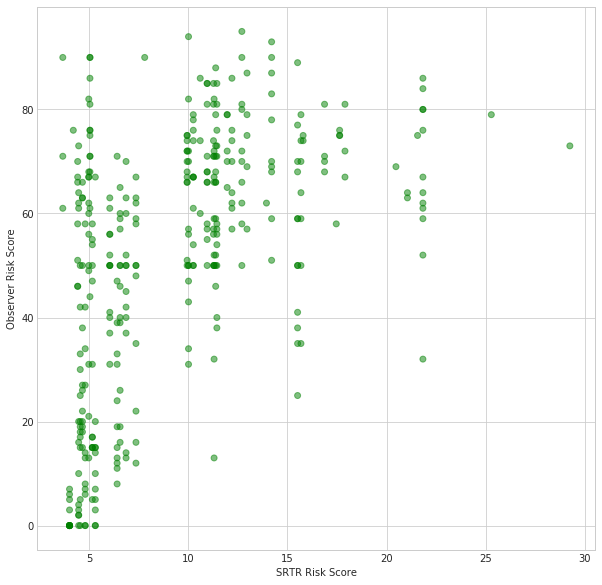

In [17]:
decision_yes = master_data['Observer Decision'] == 'Yes'

plt.figure(figsize=(10, 10))
plt.scatter(master_data[decision_yes]['SRTR Risk'], master_data[decision_yes]['Observer Risk'], color=colors[decision_yes], alpha=0.5)
plt.xlabel('SRTR Risk Score')
plt.ylabel('Observer Risk Score')

Text(0, 0.5, 'Observer Risk Score')

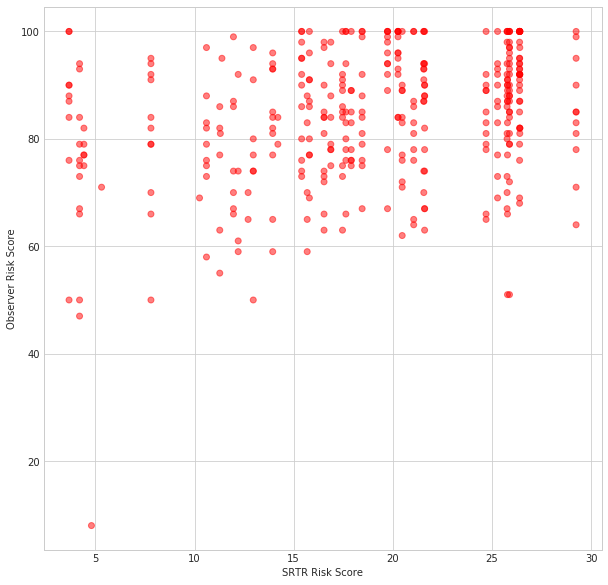

In [18]:
decision_no = master_data['Observer Decision'] == 'No'

plt.figure(figsize=(10, 10))
plt.scatter(master_data[decision_no]['SRTR Risk'], master_data[decision_no]['Observer Risk'], color=colors[decision_no], alpha=0.5)
plt.xlabel('SRTR Risk Score')
plt.ylabel('Observer Risk Score')

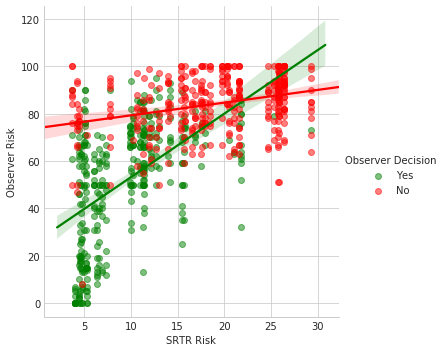

In [19]:
fit_all = sns.lmplot(x="SRTR Risk", y="Observer Risk", data=master_data, hue="Observer Decision", palette=dict(Yes="g", No="r"), scatter_kws={'alpha':0.5})

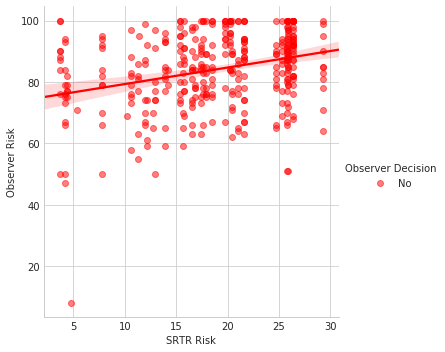

In [22]:
fit_no = sns.lmplot(x="SRTR Risk", y="Observer Risk", data=master_data[decision_no], hue="Observer Decision", palette=dict(Yes="g", No="r"), scatter_kws={'alpha':0.5})

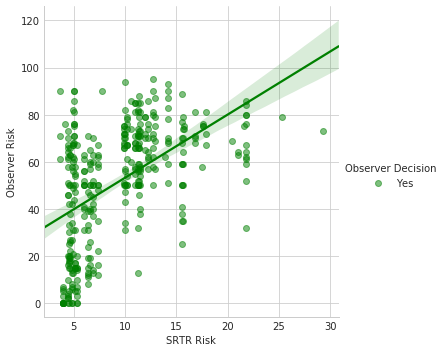

In [21]:
fit_yes = sns.lmplot(x="SRTR Risk", y="Observer Risk", data=master_data[decision_yes], hue="Observer Decision", palette=dict(Yes="g", No="r"), scatter_kws={'alpha':0.5})